# Use PPO to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:56:35 [INFO] env: <AcrobotEnv<Acrobot-v1>>
22:56:35 [INFO] action_space: Discrete(3)
22:56:35 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
22:56:35 [INFO] reward_range: (-inf, inf)
22:56:35 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
22:56:35 [INFO] _max_episode_steps: 500
22:56:35 [INFO] _elapsed_steps: None
22:56:35 [INFO] id: Acrobot-v1
22:56:35 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
22:56:35 [INFO] reward_threshold: -100.0
22:56:35 [INFO] nondeterministic: False
22:56:35 [INFO] max_episode_steps: 500
22:56:35 [INFO] _kwargs: {}
22:56:35 [INFO] _env_name: Acrobot


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        if self.memory.empty:
            self.memory = df[self.fields]
        else:
            self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.fields)

In [4]:
class PPOAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.001)
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()
                        # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'terminated', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy()
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # update actor
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * \
                advantage_tensor
        clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor
        max_surrogate_advantage_tensor = advantage_tensor + \
                torch.where(advantage_tensor > 0.,
                clip_times_advantage_tensor, -clip_times_advantage_tensor)
        clipped_surrogate_advantage_tensor = torch.min(
                surrogate_advantage_tensor, max_surrogate_advantage_tensor)
        actor_loss_tensor = -clipped_surrogate_advantage_tensor.mean()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        # update critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = PPOAgent(env)

22:56:35 [INFO] ==== train ====
22:56:36 [INFO] NumExpr defaulting to 8 threads.
22:56:36 [INFO] train episode 0: reward = -500.00, steps = 500
22:56:37 [INFO] train episode 1: reward = -500.00, steps = 500
22:56:38 [INFO] train episode 2: reward = -500.00, steps = 500
22:56:40 [INFO] train episode 3: reward = -500.00, steps = 500
22:56:41 [INFO] train episode 4: reward = -500.00, steps = 500
22:56:42 [INFO] train episode 5: reward = -500.00, steps = 500
22:56:43 [INFO] train episode 6: reward = -500.00, steps = 500
22:56:45 [INFO] train episode 7: reward = -500.00, steps = 500
22:56:46 [INFO] train episode 8: reward = -500.00, steps = 500
22:56:47 [INFO] train episode 9: reward = -500.00, steps = 500
22:56:48 [INFO] train episode 10: reward = -500.00, steps = 500
22:56:50 [INFO] train episode 11: reward = -500.00, steps = 500
22:56:51 [INFO] train episode 12: reward = -500.00, steps = 500
22:56:52 [INFO] train episode 13: reward = -500.00, steps = 500
22:56:53 [INFO] train episode 14:

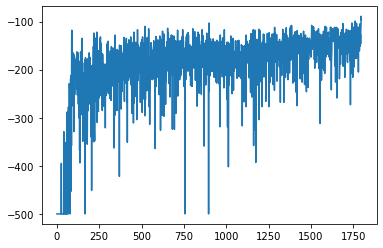

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()